In [332]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,GRU
from keras.optimizers import Adam, RMSprop
from keras.losses import binary_crossentropy

In [333]:
data_df = pd.read_csv('feat_korea_scaled.csv')
data_df

,전기전자,경상수지,오차및증감,연중최고가종목수,SELIC,서비스업,건설기성액(실질)(십억원)(동행),건설수주액(실질)(십억원)(선행),상용근로자수(천명)(후행),자본금,원유 WTI,국고채권(10년),하락종목수,제조업,재고순환지표(%p)(선행),제조업평균가동률지수(원지수),자본수지,S&amp;P/Case-Shiller주택가격지수[U.SNational],서비스수지,15세이상인구[구직기간4주],Baker Hughes 석유시추회수 월간합계,소비자기대지수(선행),실업률[한국],거래량이동평균_5,이전소득수지,종가이동평균_5,무역수지,상승종목수,건설업생산지수,제조업평균가동률지수(계절조정),구인구직비율(%)(선행),건설수주총액(경상),장단기금리차(%p)(선행),연중최저가종목수,USD,공공행정활동지수,운수장비,동행지수 순환변동치 전월차(p),월별 소비자물가등락률(전년비),경제활동참가율[구직기간4주],소득수지,선행지수 순환변동치 전월차(p),동행지수 순환변동치,코스피 200,OECD경기선행지수[한국],ICT설비투자지수(계절조정),전체종목수,금융수지,지수종가,보합종목수,금괴(일간),52주신고가종목수,날짜,COMP,NEG,NEUT,None,POS,snp500,nasdaq,shanghai,거래량,상한종목수,하한종목수,52주신저가종목수,기본 금융 금리,도시가계소비지출(실질)(천원)(후행),실업률[한국_SA]
0,-0.701396,-0.698056,0.896096,0.0,0.518497,-0.411964,-1.842618,-1.388199,-5.683130,-0.780474,-0.790210,0.869565,-0.682081,-0.712871,-0.88123,-1.285201,0.159063,-1.523747,0.783770,-0.954720,-0.227468,-1.705973,3.064491,0.262428,-0.539627,-1.227575,-0.603423,0.886228,-2.137198,-0.315130,-0.188782,-1.272385,1.007336,0.0,1.183417,-0.706837,-0.183036,-0.724404,0.513333,-2.356204,-0.531451,-1.188091,-0.371681,0.593567,-1.883504,-0.640510,0.219512,-0.106139,-1.203946,-1.173913,-0.955961,-0.461538,2001-01-08,0.005082,0.360881,0.041947,0.000518,0.591572,0.77,-0.49,-1.09,20.141025,4.290459,1.791759,0.693147,2.773214,7.616185,1.722767
1,-0.703545,-0.698056,0.896096,0.0,0.518497,-0.379233,-1.842618,-1.388199,-5.683130,-0.778791,-0.783217,0.913043,-0.658960,-0.687129,-0.88123,-1.285201,0.159063,-1.523747,0.783770,-0.954720,-0.227468,-1.705973,3.064491,0.597976,-0.539627,-1.213584,-0.603423,0.850299,-2.137198,-0.315130,-0.188782,-1.272385,1.007336,0.0,1.156616,-0.706837,-0.156250,-0.724404,0.513333,-2.356204,-0.531451,-1.188091,-0.371681,0.628655,-1.883504,-0.640510,0.219512,-0.106139,-1.200610,-1.000000,-0.957026,-0.461538,2001-01-09,0.011277,0.478814,0.085582,0.016079,0.408248,-0.27,1.89,-0.04,20.141602,4.174387,2.197225,0.693147,2.773214,7.616185,1.722767
2,-0.744361,-0.698056,0.896096,0.0,0.518497,-0.406321,-1.842618,-1.388199,-5.683130,-0.778168,-0.738928,0.913043,1.745665,-0.768317,-0.88123,-1.285201,0.159063,-1.523747,0.783770,-0.954720,-0.227468,-1.705973,3.064491,0.882984,-0.539627,-1.205596,-0.603423,-1.485030,-2.137198,-0.315130,-0.188782,-1.272385,1.007336,0.0,1.100503,-0.706837,-0.312500,-0.724404,0.513333,-2.356204,-0.531451,-1.188091,-0.371681,0.406433,-1.883504,-0.640510,0.219512,-0.106139,-1.230309,-2.130435,-0.958328,-0.423077,2001-01-10,0.000000,0.555556,0.055556,0.000000,0.388889,1.76,3.39,1.16,20.280688,3.610918,3.583519,1.098612,2.773214,7.616185,1.722767
3,-0.744361,-0.698056,0.896096,0.0,0.518497,-0.382619,-1.842618,-1.388199,-5.683130,-0.777261,-0.741259,0.869565,-0.890173,-0.780198,-0.88123,-1.285201,0.159063,-1.523747,0.783770,-0.954720,-0.227468,-1.705973,3.064491,0.944871,-0.539627,-1.204831,-0.603423,1.131737,-2.137198,-0.315130,-0.188782,-1.272385,1.007336,0.0,1.131491,-0.706837,-0.363839,-0.724404,0.513333,-2.356204,-0.531451,-1.188091,-0.371681,0.400585,-1.883504,-0.640510,0.219512,-0.106139,-1.229310,-1.260870,-0.961170,-0.500000,2001-01-11,0.007067,0.381705,0.140920,0.045477,0.424830,0.10,4.61,-0.30,20.067007,4.477337,2.484907,1.098612,2.773214,7.616185,1.722767
4,-0.705693,-0.698056,0.896096,0.0,0.518497,-0.321670,-1.842618,-1.388199,-5.683130,-0.777078,-0.724942,0.869565,-0.566474,-0.689109,-0.88123,-1.285201,0.159063,-1.523747,0.783770,-0.954720,-0.227468,-1.705973,3.064491,1.053778,-0.539627,-1.203407,-0.603423,0.652695,-2.137198,-0.315130,-0.188782,-1.272385,1.007336,0.0,1.257119,-0.706837,-0.243304,-0.724404,0.513333,-2.356204,-0.531451,-1.188091,-0.371681,0.619883,-1.883504,-0.640510,0.219512,-0.106139,-1.202702,-0.173913,-0.960696,-0.461538,2001-01-12,0.003084,0.369053,0.021311,0.000881,0.605672,-0.19,-0.53,-0.68,20.386096,3.332205,2.302585,0.693147,2.773214,7.616185,1.722767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [334]:
data_df = data_df.drop(['날짜'], axis=1, inplace=False)

In [335]:
def normalize_data(df):
    scaler = MinMaxScaler()
    for i, column in enumerate(data_df.columns):
        df[data_df.columns[i]] = scaler.fit_transform(df[data_df.columns[i]].values.reshape(-1,1))
    return df

In [336]:
normalized_data_df = data_df
normalized_data_df.describe()

,전기전자,경상수지,오차및증감,연중최고가종목수,SELIC,서비스업,건설기성액(실질)(십억원)(동행),건설수주액(실질)(십억원)(선행),상용근로자수(천명)(후행),자본금,원유 WTI,국고채권(10년),하락종목수,제조업,재고순환지표(%p)(선행),제조업평균가동률지수(원지수),자본수지,S&amp;P/Case-Shiller주택가격지수[U.SNational],서비스수지,15세이상인구[구직기간4주],Baker Hughes 석유시추회수 월간합계,소비자기대지수(선행),실업률[한국],거래량이동평균_5,이전소득수지,종가이동평균_5,무역수지,상승종목수,건설업생산지수,제조업평균가동률지수(계절조정),구인구직비율(%)(선행),건설수주총액(경상),장단기금리차(%p)(선행),연중최저가종목수,USD,공공행정활동지수,운수장비,동행지수 순환변동치 전월차(p),월별 소비자물가등락률(전년비),경제활동참가율[구직기간4주],소득수지,선행지수 순환변동치 전월차(p),동행지수 순환변동치,코스피 200,OECD경기선행지수[한국],ICT설비투자지수(계절조정),전체종목수,금융수지,지수종가,보합종목수,금괴(일간),52주신고가종목수,COMP,NEG,NEUT,None,POS,snp500,nasdaq,shanghai,거래량,상한종목수,하한종목수,52주신저가종목수,기본 금융 금리,도시가계소비지출(실질)(천원)(후행),실업률[한국_SA]
count,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000
mean,1.146351,0.271477,-0.001715,9.951631,0.146060,0.188896,0.090744,0.159935,-0.401273,-0.246400,0.062141,-0.135345,0.069964,0.241548,0.216336,-0.011917,-0.142865,0.045829,-0.145861,0.009124,0.065050,0.050198,0.079900,0.079099,-0.199944,-0.201017,0.201960,-0.007099,0.016932,-0.132661,-0.057908,0.082357,0.145465,10.676040,-0.021929,0.015067,0.436003,0.065704,0.054277,-0.089070,-0.085202,0.056905,-0.099895,0.114886,-0.192378,0.185822,0.017038,0.050175,-0.204420,-0.063736,-0.154900,0.310963,0.019328,0.377203,0.062947,0.041461,0.499060,0.020333,0.028823,0.011417,19.785980,1.983700,0.914642,2.344902,2.673903,7.009678,1.533867
std,4.959101,1.168311,1.166714,40.343737,0.751915,0.928691,0.928715,0.754510,1.864796,0.562396,0.618378,0.651016,0.769342,0.826312,0.805535,0.696514,0.891455,0.737746,1.063040,0.582381,0.553075,0.799131,0.812109,0.814847,0.762995,0.572851,0.771872,0.772788,0.802400,0.600562,0.882998,0.729658,0.817384,54.848079,0.906112,0.687935,1.328045,0.755009,0.645923,0.810511,0.653177,0.975312,0.695050,0.910905,0.872038,0.592884,0.733309,0.865180,0.576143,0.746393,0.532470,1.070629,0.007372,0.043241,0.018128,0.024389,0.045411,1.183392,1.416666,1.552455,0.369228,0.911672,0.862977,1.193191,1.031410,2.058285,0.232765
min,-0.911923,-2.133542,-4.664686,0.000000,-0.996388,-1.477427,-1.842618,-1.388199,-5.683130,-1.163211,-1.216783,-1.391304,-2.023121,-1.247525,-1.244420,-2.026176,-2.664480,-1.523747,-4.233750,-0.954720,-1.134613,-2.351647,-1.505046,-2.024052,-1.552277,-1.307915,-1.770104,-2.215569,-2.137198,-1.607163,-2.939279,-1.272385,-0.991132,0.000000,-1.878559,-1.616515,-1.058036,-1.990637,-1.086667,-2.613014,-2.460647,-2.851419,-2.973451,-1.757310,-2.715130,-0.987706,-1.487805,-3.154588,-1.324223,-3.043478,-0.970522,-0.692308,0.000000,0.000000,0.000000,0.000000,0.000000,-9.840000,-9.140000,-8.840000,18.730582,0.000000,0.000000,0.000000,1.905088,0.875469,1.386294
25%,-0.456498,-0.511458,-0.515273,0.000000,-0.371435,-0.349887,-0.530192,-0.380479,-0.324437,-0.826708,-0.407925,-0.695652,-0.456647,-0.320792,-0.308930,-0.467417,-0.657289,-0.429546,-0.601741,-0.473081,-0.409917,-0.446275,-0.476900,-0.456384,-0.635544,-0.764544,-0.351142,-0.502994,-0.487923,-0.631836,-0.491296,-0.474265,-0.502820,0.000000,-0.552764,-0.511849,-0.299107,-0.471157,-0.486667,-0.570212,-0.583087,-0.490818,-0.575221,-0.482456,-0.650605,-0.294694,-0.365854,-0.465938,-0.765069,-0.521739,-0.752930,-0.384615,0.017433,0.363337,0.058086,0.038783,0.485093,-0.430000,-0.560000,-0.650000,19.537907,1.386294,0.000

In [337]:
def generator(data, lookback=10, delay=5, min_index=0, max_index=None):
    data = data.values #DataFrame을 넘파이로 바꾸기
    max_index = len(data) - delay -1 #4439
    i = min_index + lookback #index10부터 
    samples = np.zeros((len(range(max_index-i+1)), lookback, data.shape[-1])) #(4430, 10, 33)
    targets = np.zeros((len(range(max_index-i+1)),)) #(4430,)
    while i <= max_index:
        indices = range(i-lookback, i)
        samples[i-lookback] = data[indices]
        if data[i+delay][48] - data[i][48] >= 0:
            targets[i-lookback] = 1
        else:
            targets[i-lookback] = 0
        i+=1
    return samples, targets

In [338]:
list(normalized_data_df).index('지수종가')

48

In [339]:
samples, targets = generator(normalized_data_df, min_index=0, max_index=3500)

In [340]:
def split_data(sample, target, train_size_percentage=80, shuffle=True):
    if shuffle is True:
        index = np.arange(sample.shape[0])
        np.random.shuffle(index)
        sample = sample[index]
        target = target[index]
    train_size = train_size_percentage*sample.shape[0]//100
    test_size = sample.shape[0] - train_size
    
    x_train = sample[:train_size]
    y_train = target[:train_size]
    x_test = sample[train_size:]
    y_test = target[train_size:]
    
    return x_train, y_train, x_test, y_test    

In [341]:
x_train, y_train, x_test, y_test = split_data(samples, targets)

In [342]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [343]:
model = Sequential()
model.add(GRU(32,dropout=0.1,recurrent_dropout=0.3,input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(GRU(64,dropout=0.2,recurrent_dropout=0.4, return_sequences=True))
model.add(GRU(128,dropout=0.3,recurrent_dropout=0.5, return_sequences=True))
model.add(GRU(64,dropout=0.2,recurrent_dropout=0.4))
model.add(Dense(32, activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam')

model.fit(x_train,y_train,batch_size=64,epochs=100,verbose=1,validation_split=0.25, callbacks = [es])

Epoch 1/100
42/42 [==============================] - 4s 103ms/step - loss: 0.6891 - val_loss: 0.6867
Epoch 2/100
42/42 [==============================] - 3s 77ms/step - loss: 0.6873 - val_loss: 0.6793
Epoch 3/100
42/42 [==============================] - 3s 76ms/step - loss: 0.6818 - val_loss: 0.6771
Epoch 4/100
42/42 [==============================] - 3s 79ms/step - loss: 0.6786 - val_loss: 0.6689
Epoch 5/100
42/42 [==============================] - 3s 78ms/step - loss: 0.6741 - val_loss: 0.6629
Epoch 6/100
42/42 [==============================] - 3s 78ms/step - loss: 0.6683 - val_loss: 0.6783
Epoch 7/100
42/42 [==============================] - 3s 77ms/step - loss: 0.6592 - val_loss: 0.6596
Epoch 8/100
42/42 [==============================] - 3s 78ms/step - loss: 0.6599 - val_loss: 0.6636
Epoch 9/100
42/42 [==============================] - 3s 78ms/step - loss: 0.6547 - val_loss: 0.6655
Epoch 10/100
42/42 [==============================] - 3s 77ms/step - loss: 0.6526 - val_loss: 0.671

In [344]:
def eval_acc(models, x_test_data, y_test_data, threshold=0.5):
    scores = models.predict(x_test_data)
    classified_scores=[]
    for score in scores:
        if score >= threshold:
            classified_scores.append(1)
        else:
            classified_scores.append(0)
    
    acc=0
    for i, classified_score in enumerate(classified_scores):
        if classified_score== y_test_data[i]:
            acc+=1
    accuracy_score = acc/len(y_test_data)*100
    
    return str(accuracy_score) + ' %'

In [346]:
scores = model.predict(x_test)
classified_scores=[]
for score in scores:
    if score >= 0.5:
        classified_scores.append(1)
    else:
        classified_scores.append(0)

In [348]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3544, 10, 67)
(3544,)
(886, 10, 67)
(886,)


In [349]:
data_df

,전기전자,경상수지,오차및증감,연중최고가종목수,SELIC,서비스업,건설기성액(실질)(십억원)(동행),건설수주액(실질)(십억원)(선행),상용근로자수(천명)(후행),자본금,원유 WTI,국고채권(10년),하락종목수,제조업,재고순환지표(%p)(선행),제조업평균가동률지수(원지수),자본수지,S&amp;P/Case-Shiller주택가격지수[U.SNational],서비스수지,15세이상인구[구직기간4주],Baker Hughes 석유시추회수 월간합계,소비자기대지수(선행),실업률[한국],거래량이동평균_5,이전소득수지,종가이동평균_5,무역수지,상승종목수,건설업생산지수,제조업평균가동률지수(계절조정),구인구직비율(%)(선행),건설수주총액(경상),장단기금리차(%p)(선행),연중최저가종목수,USD,공공행정활동지수,운수장비,동행지수 순환변동치 전월차(p),월별 소비자물가등락률(전년비),경제활동참가율[구직기간4주],소득수지,선행지수 순환변동치 전월차(p),동행지수 순환변동치,코스피 200,OECD경기선행지수[한국],ICT설비투자지수(계절조정),전체종목수,금융수지,지수종가,보합종목수,금괴(일간),52주신고가종목수,COMP,NEG,NEUT,None,POS,snp500,nasdaq,shanghai,거래량,상한종목수,하한종목수,52주신저가종목수,기본 금융 금리,도시가계소비지출(실질)(천원)(후행),실업률[한국_SA]
0,-0.701396,-0.698056,0.896096,0.0,0.518497,-0.411964,-1.842618,-1.388199,-5.683130,-0.780474,-0.790210,0.869565,-0.682081,-0.712871,-0.88123,-1.285201,0.159063,-1.523747,0.783770,-0.954720,-0.227468,-1.705973,3.064491,0.262428,-0.539627,-1.227575,-0.603423,0.886228,-2.137198,-0.315130,-0.188782,-1.272385,1.007336,0.0,1.183417,-0.706837,-0.183036,-0.724404,0.513333,-2.356204,-0.531451,-1.188091,-0.371681,0.593567,-1.883504,-0.640510,0.219512,-0.106139,-1.203946,-1.173913,-0.955961,-0.461538,0.005082,0.360881,0.041947,0.000518,0.591572,0.77,-0.49,-1.09,20.141025,4.290459,1.791759,0.693147,2.773214,7.616185,1.722767
1,-0.703545,-0.698056,0.896096,0.0,0.518497,-0.379233,-1.842618,-1.388199,-5.683130,-0.778791,-0.783217,0.913043,-0.658960,-0.687129,-0.88123,-1.285201,0.159063,-1.523747,0.783770,-0.954720,-0.227468,-1.705973,3.064491,0.597976,-0.539627,-1.213584,-0.603423,0.850299,-2.137198,-0.315130,-0.188782,-1.272385,1.007336,0.0,1.156616,-0.706837,-0.156250,-0.724404,0.513333,-2.356204,-0.531451,-1.188091,-0.371681,0.628655,-1.883504,-0.640510,0.219512,-0.106139,-1.200610,-1.000000,-0.957026,-0.461538,0.011277,0.478814,0.085582,0.016079,0.408248,-0.27,1.89,-0.04,20.141602,4.174387,2.197225,0.693147,2.773214,7.616185,1.722767
2,-0.744361,-0.698056,0.896096,0.0,0.518497,-0.406321,-1.842618,-1.388199,-5.683130,-0.778168,-0.738928,0.913043,1.745665,-0.768317,-0.88123,-1.285201,0.159063,-1.523747,0.783770,-0.954720,-0.227468,-1.705973,3.064491,0.882984,-0.539627,-1.205596,-0.603423,-1.485030,-2.137198,-0.315130,-0.188782,-1.272385,1.007336,0.0,1.100503,-0.706837,-0.312500,-0.724404,0.513333,-2.356204,-0.531451,-1.188091,-0.371681,0.406433,-1.883504,-0.640510,0.219512,-0.106139,-1.230309,-2.130435,-0.958328,-0.423077,0.000000,0.555556,0.055556,0.000000,0.388889,1.76,3.39,1.16,20.280688,3.610918,3.583519,1.098612,2.773214,7.616185,1.722767
3,-0.744361,-0.698056,0.896096,0.0,0.518497,-0.382619,-1.842618,-1.388199,-5.683130,-0.777261,-0.741259,0.869565,-0.890173,-0.780198,-0.88123,-1.285201,0.159063,-1.523747,0.783770,-0.954720,-0.227468,-1.705973,3.064491,0.944871,-0.539627,-1.204831,-0.603423,1.131737,-2.137198,-0.315130,-0.188782,-1.272385,1.007336,0.0,1.131491,-0.706837,-0.363839,-0.724404,0.513333,-2.356204,-0.531451,-1.188091,-0.371681,0.400585,-1.883504,-0.640510,0.219512,-0.106139,-1.229310,-1.260870,-0.961170,-0.500000,0.007067,0.381705,0.140920,0.045477,0.424830,0.10,4.61,-0.30,20.067007,4.477337,2.484907,1.098612,2.773214,7.616185,1.722767
4,-0.705693,-0.698056,0.896096,0.0,0.518497,-0.321670,-1.842618,-1.388199,-5.683130,-0.777078,-0.724942,0.869565,-0.566474,-0.689109,-0.88123,-1.285201,0.159063,-1.523747,0.783770,-0.954720,-0.227468,-1.705973,3.064491,1.053778,-0.539627,-1.203407,-0.603423,0.652695,-2.137198,-0.315130,-0.188782,-1.272385,1.007336,0.0,1.257119,-0.706837,-0.243304,-0.724404,0.513333,-2.356204,-0.531451,-1.188091,-0.371681,0.619883,-1.883504,-0.640510,0.219512,-0.106139,-1.202702,-0.173913,-0.960696,-0.461538,0.003084,0.369053,0.021311,0.000881,0.605672,-0.19,-0.53,-0.68,20.386096,3.332205,2.302585,0.693147,2.773214,7.616185,1.722767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [350]:
y_test

array([1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1.,
       1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1.,
       0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0.,
       1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
       1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1.,
       1., 1., 0., 0., 0.

In [351]:
scores = model.predict(x_test)
classified_scores=[]
for score in scores:
    if score >= 0.5:
        classified_scores.append(1)
    else:
        classified_scores.append(0)
print(classified_scores)
print(len(classified_scores))

[1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 

In [352]:
data_df1 = pd.read_csv('122630.csv')
data_df1.head(-1)

,날짜,종가,오픈,고가,저가,거래량,변동 %
0,2018년 12월 28일,"11,445","11,375","11,530","11,370",11.57M,0.93%
1,2018년 12월 27일,"11,340","11,405","11,430","11,280",14.01M,2.81%
2,2018년 12월 26일,"11,030","11,065","11,200","10,915",19.48M,-2.90%
3,2018년 12월 24일,"11,360","11,310","11,370","11,225",8.05M,-0.09%
4,2018년 12월 21일,"11,370","11,330","11,405","11,275",11.37M,-0.04%
...,...,...,...,...,...,...,...
1041,2015년 05월 29일,"11,590","11,440","11,710","11,420",15.95M,0.78%
1042,2015년 05월 28일,"11,500","11,600","11,660","11,500",15.75M,0.00%
1043,2015년 05월 27일,"11,500","11,840","11,880","11,455",29.40M,-4.13%
1044,2015년 05월 26일,"11,995","12,045","12,075","11,905",11.34M,-0.42%


In [353]:
data_df = pd.read_csv('final2.csv')
a = list(np.array(data_df1["날짜"].tolist()))
for i in range(len(a)):
  a[i] = a[i].replace('년 ','-')
  a[i] = a[i].replace('월 ','-')
  a[i] = a[i].replace('일','')
data_df1["날짜"] = a
a = list(np.array(data_df1["종가"].tolist()))
for i in range(len(a)):
  a[i] = a[i].replace(',','')
  a[i] = int(a[i])
data_df1['종가'] = a
data_df1.drop(['오픈',	'고가',	'저가',	'거래량',	'변동 %'],axis=1,inplace=True)
data_df1.head(-1)

,날짜,종가
0,2018-12-28,11445
1,2018-12-27,11340
2,2018-12-26,11030
3,2018-12-24,11360
4,2018-12-21,11370
...,...,...
1041,2015-05-29,11590
1042,2015-05-28,11500
1043,2015-05-27,11500
1044,2015-05-26,11995


In [354]:
final = pd.merge(data_df, data_df1, how='left', on='날짜')
final.head(-1)

,날짜,지수종가,종가이동평균_5,거래량,거래량이동평균_5,자본금,전체종목수,상승종목수,하락종목수,보합종목수,상한종목수,하한종목수,연중최고가종목수,연중최저가종목수,52주신고가종목수,52주신저가종목수,변동률,금괴(일간),국고채권(10년),원유 WTI,USD,코스피 200,제조업,전기전자,운수장비,서비스업,snp500,nasdaq,shanghai,COMP,NEG,NEUT,None,POS,15세이상인구[구직기간4주],4주평균신규실업보험청구자수NSA[미국],Baker Hughes 석유시추회수 월간합계,ICT설비투자지수(계절조정),ISM비제조업지수[미국],ISM제조업지수[미국],...,산업생산[네덜란드](SA),산업생산[룩셈부르크],"산업생산[브라질, NSA]",산업생산[스페인],산업생산[핀란드],상용근로자수(천명)(후행),상품가격지수[미국],서비스수지,선행지수 순환변동치 전월차(p),소득수지,소매물가지수(농촌)[중국],소비자기대지수(선행),소비자물가(SA)[일본],소비자물가[인도],소비자물가상승율[브라질],수입지수[미국],수출국(멕시코),수출국(미국),수출국(이탈리아),수출국(칠레),신규수출주문지수[미국],실업률[스위스_NSA],실업률[오스트리아_NSA],실업률[핀란드_NSA],실업률[한국],실업률[한국_SA],오차및증감,월별 소비자물가등락률(전년비),이전소득수지,자동차판매[AutoSales][미국],자본금융수지[브라질],자본수지,장단기금리차(%p)(선행),재고순환지표(%p)(선행),재고지수[미국],재정수지[미국],제조업평균가동률지수(계절조정),제조업평균가동률지수(원지수),직접투자[브라질],종가
0,2001-01-08,586.65,553.580,558645100,19.873264,84853590,902,533,278,45,72,5,0,0,6,1,2.105173,268.3,6.6,27.3,1267.8,15.04,9.40,7.41,9.22,11.03,0.77,-0.49,-1.09,0.005082,0.360881,0.041947,0.000518,0.591572,36405.0,500976.00,1118.0,89.5,51.6,42.3,...,94.35,89.27,91.83,98.800,93.2,6573.3,64.6,23.2000,-0.5,-2.460,99.30,84.9,102.67,96.11,5.900000,49.0,97.366,1.219045e+09,150.691,98.531,46.2,1.83,7.7,9.9,5.1,4.6,8.840,3.4,66.875,8708.40,5.404533,-10.965500,1.35,-10.8,41.6,76379.0,95.1,86.9,-1568.746882,NaN
1,2001-01-09,589.92,567.374,558967700,20.016030,84881174,902,527,282,49,64,8,0,0,6,1,2.288446,267.4,6.7,27.6,1264.6,15.16,9.53,7.39,9.34,11.32,-0.27,1.89,-0.04,0.011277,0.478814,0.085582,0.016079,0.408248,36405.0,500976.00,1118.0,89.5,51.6,42.3,...,94.35,89.27,91.83,98.800,93.2,6573.3,64.6,23.2000,-0.5,-2.460,99.30,84.9,102.67,96.11,5.900000,49.0,97.366,1.219045e+09,150.691,98.531,46.2,1.83,7.7,9.9,5.1,4.6,8.840,3.4,66.875,8708.40,5.404533,-10.965500,1.35,-10.8,41.6,76379.0,95.1,86.9,-1568.746882,NaN
2,2001-01-10,560.81,575.250,642378200,20.137292,84891369,902,137,698,23,36,35,0,0,7,2,6.244539,266.3,6.7,29.5,1257.9,14.40,9.12,7.01,8.64,11.08,1.76,3.39,1.16,0.000000,0.555556,0.055556,0.000000,0.388889,36405.0,500976.00,1118.0,89.5,51.6,42.3,...,94.35,89.27,91.83,98.800,93.2,6573.3,64.6,23.2000,-0.5,-2.460,99.30,84.9,102.67,96.11,5.900000,49.0,97.366,1.219045e+09,150.691,98.531,46.2,1.83,7.7,9.9,5.1,4.6,8.840,3.4,66.875,8708.40,5.404533,-10.965500,1.35,-10.8,41.6,76379.0,95.1,86.9,-1568.746882,NaN
3,2001-01-11,561.79,576.004,518788600,20.163623,84906240,902,574,242,43,87,11,0,0,5,2,7.522384,263.9,6.6,29.4,1261.6,14.38,9.06,7.01,8.41,11.29,0.10,4.61,-0.30,0.007067,0.381705,0.140920,0.045477,0.424830,36405.0,500976.00,1118.0,89.5,51.6,42.3,...,94.35,89.27,91.83,98.800,93.2,6573.3,64.6,23.2000,-0.5,-2.460,99.30,84.9,102.67,96.11,5.900000,49.0,97.366,1.219045e+09,150.691,98.531,46.2,1.83,7.7,9.9,5.1,4.6,8.840,3.4,66.875,8708.40,5.404533,-10.965500,1.35,-10.8,41.6,76379.0,95.1,86.9,-1568.746882,NaN
4,2001-01-12,587.87,577.408,713787700,20.209960,84909240,902,494,298,68,27,9,0,0,6,1,5.428071,264.3,6.6,30.1,1276.6,15.13,9.52,7.37,8.95,11.83,-0.19,-0.53,-0.68,0.003084,0.369053,0.021311,0.000881,0.605672,36405.0,500976.00,1118.0,89.5,51.6,42.3,...,94.35,89.27,91.83,98.800,93.2,6573.3,64.6,23.2000,-0.5,-2.460,99.30,84.9,102.67,96.11,5.900000,49.0,97.366,1.219045e+09,150.691,98.531,46.2,1.83,7.7,9.9,5.1,4.6,8.840,3.4,66.875,8708.40,5.404533,-10.965500,1.35,-10.8,41.6,76379.0,95.1,86.9,-1568.746882,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4439,2018-12-20,2060.12,2068.308,421064800,19.884932,107901620,900,310,519,66,0,0,0,0,42,111,-0.926160,1258.1,1.9,45.9,1125.1,8.63,8.87,5.47,53.81,25.45,-1.63,-1.63,-0.52,0.021093,0.367760,0.057850,0.039166,0.514130,44284.0,224007.25,1077.0,104.5,60.7,59.3,...,95.40,105.10,89.90,109.483,110.8,26866.3,60.7,-1141.9165,-0.2,8.064,102.19,92.2,101.60,140.80

In [355]:
final[-886:].isnull().sum()

날짜                  0
지수종가                0
종가이동평균_5            0
거래량                 0
거래량이동평균_5           0
                   ..
재정수지[미국]            0
제조업평균가동률지수(계절조정)    0
제조업평균가동률지수(원지수)     0
직접투자[브라질]           0
종가                  0
Length: 133, dtype: int64

In [356]:
df = pd.DataFrame()
df['x'] = final['종가'][-886:]
df['y']=classified_scores

In [357]:
df.head(-1)

,x,y
3559,12045.0,1
3560,11995.0,0
3561,11500.0,0
3562,11500.0,0
3563,11590.0,1
...,...,...
4439,11375.0,1
4440,11370.0,1
4441,11360.0,1
4442,11030.0,0


In [358]:
df.describe()

,x,y
count,886.000000,886.000000
mean,12908.865688,0.564334
std,2965.958717,0.496124
min,8330.000000,0.000000
25%,10340.000000,0.000000
50%,12022.500000,1.000000
75%,15890.000000,1.000000
max,19095.000000,1.000000


In [359]:
money = 100000000
stock = 0
aa=[]
price = [[],[],[],[],[]]
for j in range(5):
    money = 100000000
    stock = 0
    for i in range(j,886,5):
        a = []
        x=df['x'].iloc[i]
        y=df['y'].iloc[i]
        if y == 1 and money>0:
            stock = money/x
            money = 0
        if y == 0 and money==0:
            money = stock*x
            stock = 0
        a.append(money)
        a.append(stock)
        if money ==0:
          price[j].append(stock*x)
        else:
          price[j].append(money)
    if a[0]==0:
        print(a[1]*x)
        aa.append(a[1]*x)
    else:
        print(a[0])
        aa.append(a[0])
      
#요일별 최종 백테스팅 가격

60061325.34284791
110096529.37410678
133437642.63901764
94834174.39339434
163254417.04575536


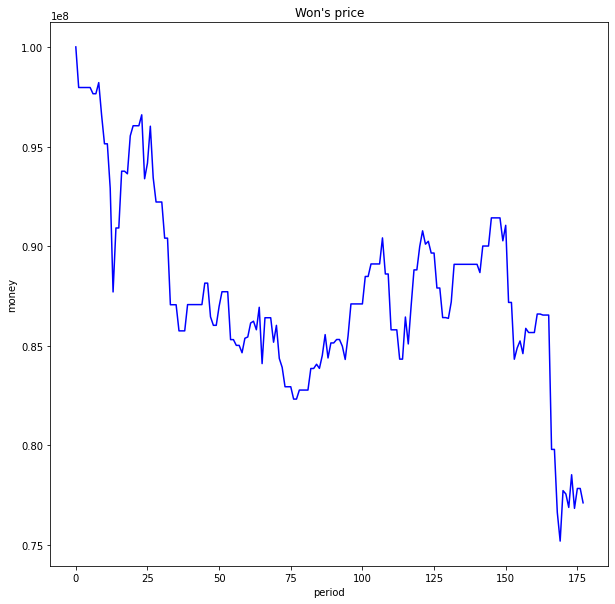

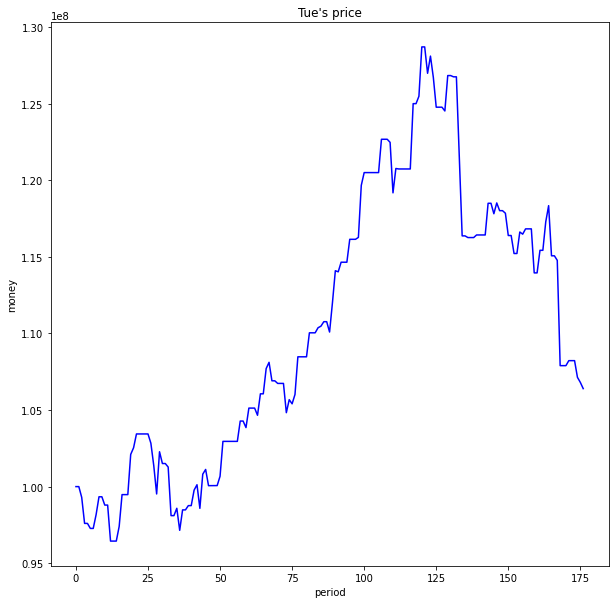

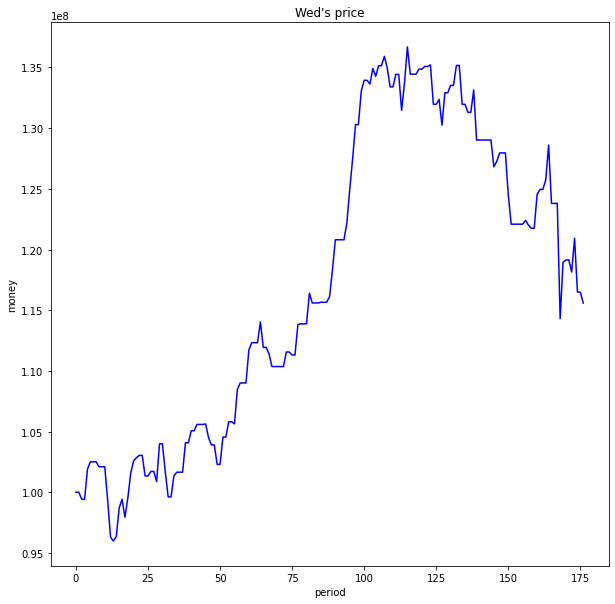

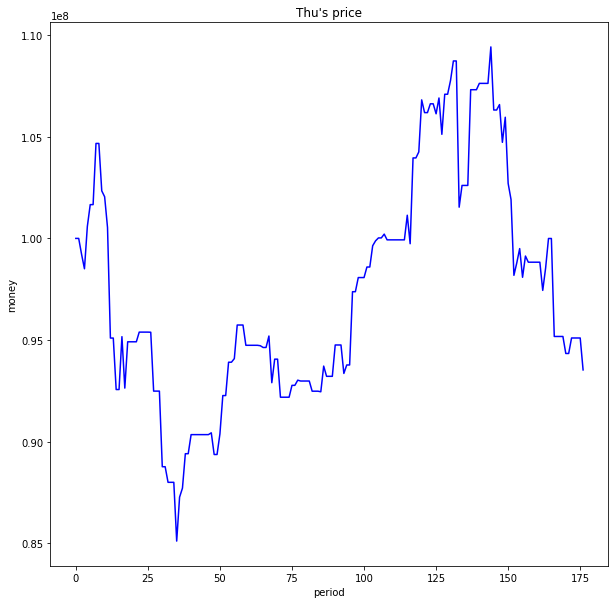

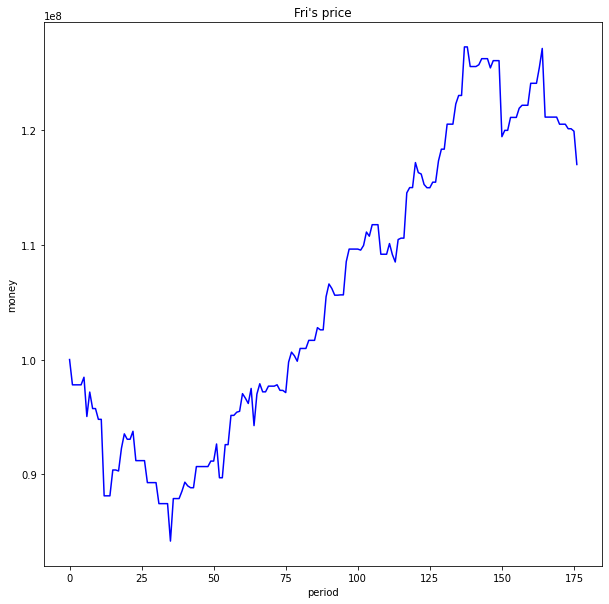

In [366]:
import matplotlib.pyplot as plt
asd = ['Won','Tue','Wed','Thu','Fri']
for i in range(5):
  plt.figure(figsize=(10, 10))
  plt.title(asd[i] + "'s price")  
  plt.xlabel('period')
  plt.ylabel('money')
  plt.plot(range(len(price[i])),price[i],color='b')
  plt.show()

  # 요일별 그래프

In [361]:
print(sum(aa)/5000000) # 딥러닝 최종 백테스팅

112.3368177590244


In [362]:
print(df['x'].iloc[-1]*100/df['x'].iloc[0])  # 첫날 투자 마지막날 가격

95.0186799501868


In [345]:
eval_acc(model, x_test, y_test) #accuaracy

'74.15349887133182 %'

In [347]:
from sklearn.metrics import f1_score

f1_score(y_test, classified_scores) # f1 score

0.7721393034825871